# Plot probability density of CWV, precip, SST, and surface winds
- CWV from radiosondes
- Precip from SEA-POL (IMERG for now)
- SST from sea snake (TSG for now)
- Surface winds from DSHIP

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from thermo_functions import *
from time_series_diag import *
from bowtie_read_data import *

In [2]:
#Set start and end times
start_time = np.datetime64('2024-08-16T07:00:00')
end_time = np.datetime64('2024-09-23T22:59:00')

#Set E/W boundary
lonEW = -40

# DSHIP data

In [3]:
#Open ship data
DSHIP = xr.open_dataset('../../data/meteor_meteo_dship_20240923.nc')
DSHIP

<xarray.Dataset> Size: 20MB
Dimensions:           (time: 58980)
Coordinates:
  * time              (time) datetime64[ns] 472kB 2024-08-14 ... 2024-09-23T2...
    lat               (time) float64 472kB ...
    lon               (time) float64 472kB ...
Data variables: (12/39)
    sst_port          (time) float64 472kB ...
    sst_extern_port   (time) float64 472kB ...
    sst_intern_port   (time) float64 472kB ...
    sst_board         (time) float64 472kB ...
    sst_extern_board  (time) float64 472kB ...
    sst_intern_board  (time) float64 472kB ...
    ...                ...
    ship_heave        (time) float64 472kB ...
    ship_heave_std    (time) float64 472kB ...
    ship_pitch        (time) float64 472kB ...
    ship_pitch_std    (time) float64 472kB ...
    ship_roll         (time) float64 472kB ...
    ship_roll_std     (time) float64 472kB ...

In [4]:
#Find indices for start and end times
index_start = np.where(pd.to_datetime(DSHIP.time) == start_time)[0]
index_start = int(index_start[0])

index_end = np.where(pd.to_datetime(DSHIP.time) == end_time)[0]
index_end = int(index_end[0])

In [9]:
# Smooth wind speed and SST with an hourly running mean, restrict to the time period of interest
wspd_smoothed = DSHIP.wspd[index_start:index_end+1].rolling(time=60, center=True).mean() # 60 minute running mean
#sst_smoothed = DSHIP.sst_port[index_start:index_end+1].rolling(time=60, center=True).mean() # 60 minute running mean
shipLON = DSHIP.lon[index_start:index_end+1]
shipLAT = DSHIP.lat[index_start:index_end+1]
shipTIME = DSHIP.time[index_start:index_end+1]

#Find time when ship crosses 40W
iEW = np.where(shipLON <= lonEW)[0]
iEW = int(iEW[0])
timeEW = shipTIME[iEW]

# Split into East/West
wspd_smoothedE = wspd_smoothed.where(shipLON > lonEW, drop=True)
wspd_smoothedW = wspd_smoothed.where(shipLON <= lonEW, drop=True)
#sst_smoothedE = sst_smoothed.where(shipLON > lonEW, drop=True)
#sst_smoothedW = sst_smoothed.where(shipLON <= lonEW, drop=True)

# Calibrated Thermosalinograph Data

In [6]:
tsg = xr.open_dataset('../../data/M203_surf_oce.nc')
tsg

<xarray.Dataset> Size: 5MB
Dimensions:    (TIME: 56467, NO_OF_TEMPERATURES: 2, NO_OF_SALINITIES: 2,
                DEPTH: 1)
Coordinates:
  * TIME       (TIME) datetime64[ns] 452kB 2024-08-16T02:52:59.999998 ... 202...
  * DEPTH      (DEPTH) float64 8B 5.0
Dimensions without coordinates: NO_OF_TEMPERATURES, NO_OF_SALINITIES
Data variables:
    LATITUDE   (TIME) float64 452kB ...
    LONGITUDE  (TIME) float64 452kB ...
    TEMP       (TIME, NO_OF_TEMPERATURES) float64 903kB ...
    TEMP_QC    (TIME) int8 56kB ...
    PSAL       (TIME, NO_OF_SALINITIES) float64 903kB ...
    PSAL_QC    (TIME) int8 56kB ...
    COND       (TIME) float64 452kB ...
    MC         (TIME) <U4 903kB ...
Attributes:
    history:            Created Thu Jan 23 14:04:53 2025
    contributor_name:   ['Daniel Klocke', 'Marcus Dengler', 'Michael Schlundt']
    contributor_role:   ['Chief Scientist of the Cruise', 'Principal Investig...
    contributor_email:  ['daniel.klocke@mpimet.mpg.de', 'mdengler@geomar.de',...
    chief_scientist:    see contributor_name attribute
    cruise_identifier:  M203
    expocode:           06M320240810
    cruise_leg:         1
    ship_name:          Meteor

In [7]:
# Find time indices for start and end times
i1_TSG = np.abs(tsg.TIME - start_time).argmin()
i1_TSG = int(i1_TSG)

i2_TSG = np.abs(tsg.TIME - end_time).argmin()
i2_TSG = int(i2_TSG)

In [23]:
#Smooth SST with an hourly running mean, restrict to the time period of interest
sst_smoothed = tsg.TEMP[i1_TSG:i2_TSG+1,0].rolling(TIME=60, center=True).mean()+273.15 # 60 minute running mean

#Split into East/West
iEW_TSG = np.abs(tsg.TIME[i1_TSG:i2_TSG+1] - timeEW).argmin()
iEW_TSG = int(iEW_TSG)

sst_smoothedE = sst_smoothed[0:iEW_TSG] 
sst_smoothedW = sst_smoothed[iEW_TSG:]                                  

# Radiosonde data

In [12]:
# Soundings
snd_asc, snd_files, times_asc = read_bowtie_soundings(search_string = 'ascen')
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'descen')
hght = snd_asc['hght']

Define functions

In [13]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int


Calculate column-integrated water vapor

In [14]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

In [15]:
# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['mr'], snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght, minpres=0) # mm or kg/m2

In [16]:
#Mask out soundings that don't reach 100 hPa
 
nt = snd_asc['p'].shape[0]
min_pres = np.zeros(nt)
for isnd in range(nt):
    min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa
cwv = np.ma.masked_where((min_pres > 100), cwv, copy=False)

/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_89189/1962452099.py:6: RuntimeWarning: All-NaN slice encountered
  min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa


In [17]:
# Convert datetime arrays to numeric type (minutes since a reference time)
ref_time = np.datetime64('1970-01-01T00:00:00')
times_asc_minutes = (times_asc - ref_time) / np.timedelta64(1, 'm')
DSHIP_time_minutes = (DSHIP.time - ref_time) / np.timedelta64(1, 'm')

# Find longitude by interpolating time of sounding to ship time
sondeLON = np.interp(times_asc_minutes, DSHIP_time_minutes, DSHIP.lon)

# Mask out soundings before start_time
cwv = np.ma.masked_where(times_asc < start_time, cwv, copy=False)
sondeLON = np.ma.masked_where(times_asc < start_time, sondeLON, copy=False)

# Split into east and west
cwvE = cwv[sondeLON > lonEW]
cwvW = cwv[sondeLON <= lonEW]

In [18]:
finite = np.where(np.isfinite(cwv))
cwv_finite = cwv[finite]

finite = np.where(np.isfinite(cwvE))
cwvE_finite = cwvE[finite]

finite = np.where(np.isfinite(cwvW))
cwvW_finite = cwvW[finite]

# Precipitation data

In [ ]:
#imerg = xr.open_dataset('../../data/IMERG/meteor_IMERG_range1.2deg.nc')
#imerg

In [14]:
#Find longitude by interpolating time of precip data to ship time
#imerg_time_minutes = (imerg.time - ref_time) / np.timedelta64(1, 'm')
#imergLON = np.interp(imerg_time_minutes, DSHIP_time_minutes, DSHIP.lon)

#Split into east and west
#precip = imerg.mean_precipitation
#precipE = imerg.mean_precipitation[imergLON > lonEW]
#precipW = imerg.mean_precipitation[imergLON <= lonEW]

In [19]:
disdro = xr.open_dataset('../../data/disdrometer/RES_meteor2_joined.nc')
disdro

<xarray.Dataset> Size: 500MB
Dimensions:                            (time: 56160, particle_size: 32,
                                        raw_fall_velocity: 32)
Coordinates:
  * time                               (time) datetime64[ns] 449kB 2024-08-16...
  * particle_size                      (particle_size) float32 128B 0.062 ......
  * raw_fall_velocity                  (raw_fall_velocity) float32 128B 0.05 ...
Data variables: (12/56)
    particle_size_bin_width            (time, particle_size) float32 7MB ...
    raw_fall_velocity_bin_width        (time, raw_fall_velocity) float32 7MB ...
    precip_rate                        (time) float32 225kB ...
    weather_code                       (time) float32 225kB ...
    equivalent_radar_reflectivity_ott  (time) float32 225kB ...
    number_detected_particles          (time) float32 225kB ...
    ...                                 ...
    zdr_x                              (time) float32 225kB ...
    delta_co_x                         (time) float32 225kB ...
    kdp_x                              (time) float32 225kB ...
    ai_x                               (time) float32 225kB ...
    adr_x                              (time) float32 225kB ...
    conv_strat                         (time) float32 225kB ...
Attributes: (12/21)
    description:                     ... METEOR PARSIVEL Disdrometer Dataset ...
    station_id:                      METEOR2
    sampling_period:                 60 Seconds
    history:                         Converted to netCDF4 at 2024-12-17 21:12...
    analysis_date:                   2024-08-16
    compression_level:               4
    ...                              ...
    tmatrix_canting_mean_angle:      0.0 degrees
    tmatrix_canting_std:             7.5 degrees
    tmatrix_drop_model:              Thurai and Bringi (2005)
    simulated_s_freq:                2997924580 Hz
    simulated_c_freq:                5995849160 Hz
    simulated_x_freq:                9993081933 Hz

In [20]:
#Find indices for start and end times
index_start_disdro = np.where(pd.to_datetime(disdro.time) == start_time)[0]
index_start_disdro = int(index_start_disdro[0])

index_end_disdro = np.where(pd.to_datetime(disdro.time) == end_time)[0]
index_end_disdro = int(index_end_disdro[0])

# Smooth with an hourly running mean, restrict to the time period of interest
precip = disdro.rain_rate_qc[index_start_disdro:index_end_disdro+1].rolling(time=60, center=True).mean() # 60 minute running mean
disdroLON = disdro.lon[index_start_disdro:index_end_disdro+1]
disdroLAT = disdro.lat[index_start_disdro:index_end_disdro+1]

In [21]:
#Split into east and west
precipE = precip[disdroLON > lonEW]
precipW = precip[disdroLON <= lonEW]

# Make probability density plot

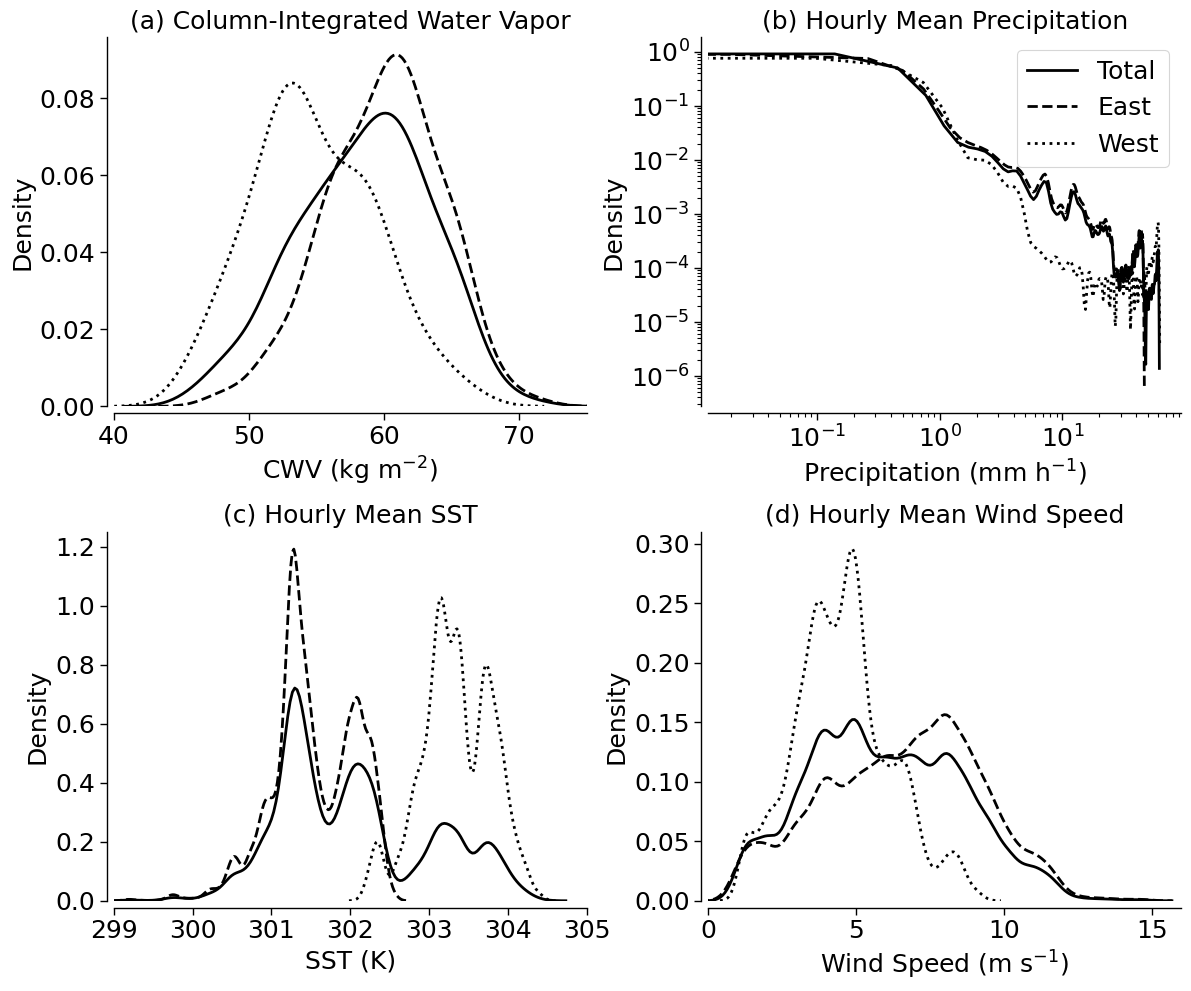

In [25]:
fig, axs = plt.subplots(2,2,figsize=(12,10))

sns.kdeplot(cwv_finite, ax=axs[0,0],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(cwvE_finite, ax=axs[0,0],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(cwvW_finite, ax=axs[0,0],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,0].set_title('(a) Column-Integrated Water Vapor',fontsize=18)
axs[0,0].set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0,0].set_ylabel('Density',fontsize=18)
axs[0,0].set_xlim(40,75)
#axs[0,0].legend(fontsize=18)
axs[0,0].tick_params(labelsize=18)

sns.kdeplot(precip, ax=axs[0,1],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(precipE, ax=axs[0,1],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(precipW, ax=axs[0,1],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[0,1].set_title('(b) Hourly Mean Precipitation',fontsize=18)
axs[0,1].set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
axs[0,1].set_ylabel('Density',fontsize=18)
#axs[0,1].set_xlim(0,5)
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].legend(fontsize=18)
axs[0,1].tick_params(labelsize=18)

sns.kdeplot(sst_smoothed, ax=axs[1,0],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(sst_smoothedE, ax=axs[1,0],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(sst_smoothedW, ax=axs[1,0],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[1,0].set_title('(c) Hourly Mean SST',fontsize=18)
axs[1,0].set_xlabel('SST (K)',fontsize=18)
axs[1,0].set_ylabel('Density',fontsize=18)
axs[1,0].set_xlim(299,305)
#axs[1,0].legend(fontsize=18)
axs[1,0].tick_params(labelsize=18)

sns.kdeplot(wspd_smoothed, ax=axs[1,1],label='Total',fill=False,common_norm=False,color='black',linewidth=2)
sns.kdeplot(wspd_smoothedE, ax=axs[1,1],label='East',fill=False,common_norm=False,color='black',linestyle='--',linewidth=2)
sns.kdeplot(wspd_smoothedW, ax=axs[1,1],label='West',fill=False,common_norm=False,color='black',linestyle=':',linewidth=2)

axs[1,1].set_title('(d) Hourly Mean Wind Speed',fontsize=18)
axs[1,1].set_xlabel('Wind Speed (m s$^{-1}$)',fontsize=18)
axs[1,1].set_ylabel('Density',fontsize=18)
#axs[1,1].legend(fontsize=18)
axs[1,1].set_xlim(0,16)
axs[1,1].tick_params(labelsize=18)


sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig('../figures/Fig_pdf_EW.png')
